<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/05_mnist_nice_son.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

In [2]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.data[idx]
        y = self.dataset.targets[idx]
        return x, y

In [3]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(input_dim), requires_grad=True)


    def forward(self, x):
        x = x[0].to(torch.float32)
        x = x.view(len(x), -1,) / 255
        return self.f(x)

    def coupling_layer(self, x, m, flow, forward=True):
        x = x.clone()

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = (x_b - m(x_a))
        else:
            y_b = (x_b + m(x_a))

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a
        return z


    def f(self, x):
        z = x

        for flow, model in enumerate(self.m, start=0):
            z = self.coupling_layer(z, model, flow, forward=True)

        z = z * torch.exp(self.s)
        log_det_j = self.s.reshape(-1,1)

        return z, log_det_j

    def f_inv(self, z):
        x = z / torch.exp(self.s)

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            x = self.coupling_layer(x, model, flow,forward=False)

        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) + log_det_j).mean()
        return loss

In [4]:
train_image = torchvision.datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
test_image = torchvision.datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())



train_data = Data(train_image)
test_data = Data(test_image)

100%|██████████| 9912422/9912422 [00:00<00:00, 245162935.44it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 112684366.35it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 92123446.78it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2514257.46it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



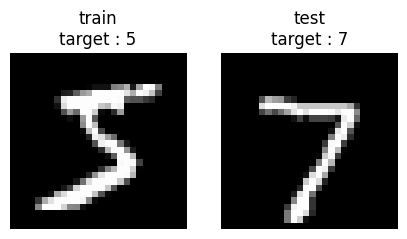

In [5]:
image_train, category_train = train_data[0]
image_test, category_test = test_data[0]


plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((28,28)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((28,28)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [6]:
data_dim = 28*28
prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))

model = NICE(input_dim=data_dim, hidden_layer=128, num_flows=10)

train_loader = DataLoader(train_data, batch_size=10000, shuffle=True)


In [7]:
epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%1 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  822.294667561849
Epoch :  2   -----------> Loss :  791.9211832682291
Epoch :  3   -----------> Loss :  782.7786560058594
Epoch :  4   -----------> Loss :  773.4451802571615
Epoch :  5   -----------> Loss :  765.7327779134115
Epoch :  6   -----------> Loss :  759.652353922526
Epoch :  7   -----------> Loss :  754.3229675292969
Epoch :  8   -----------> Loss :  749.9232991536459
Epoch :  9   -----------> Loss :  746.6592203776041
Epoch :  10   -----------> Loss :  744.020751953125
Epoch :  11   -----------> Loss :  741.8758138020834
Epoch :  12   -----------> Loss :  740.774169921875
Epoch :  13   -----------> Loss :  739.0570983886719
Epoch :  14   -----------> Loss :  737.6383361816406
Epoch :  15   -----------> Loss :  736.8695983886719
Epoch :  16   -----------> Loss :  736.0606282552084
Epoch :  17   -----------> Loss :  734.9295450846354
Epoch :  18   -----------> Loss :  734.045908610026
Epoch :  19   -----------> Loss :  733.271250406901
Epoch : 

KeyboardInterrupt: ignored

In [ ]:
plt.plot(COST)

In [ ]:
test = prior.sample((50,))
test

In [ ]:
sonuc = model.f_inv(test)


In [ ]:
test = prior.sample((10,))
sonuc = model.f_inv(test)

fig, axs = plt.subplots(1, 10, sharex=True, sharey=True, figsize=(16, 8))

for i in range(0,10):

    axs[i].imshow(sonuc[i].detach().numpy().reshape((28,28)), cmap='gray')
    #axs[i].axis('off')

fig.show()